# Power System Co-simulation Fundamentals

| Information | Details |
|----------|---------|
| Lead Authors | Xin Fang, Hantao Cui|
| Learning Objectives | • Understand transmission and distribution system characteristics<br>• Explain the need for separate power system simulators<br>• Understand co-simulation architecture concepts<br>• Learn interface data exchange principles<br>• Complete manual power flow calculations<br>• Prepare for full implementation in next notebooks |
| Prerequisites | HELICS fundamentals, Python programming, basic power systems knowledge |
| Estimated Time | 90 minutes |
| Topics | Transmission vs distribution systems, co-simulation motivation<br>Interface design, manual calculations, architecture concepts |

In [1]:
# Environment check and setup
import sys
import importlib

print("Checking environment...")
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

# Check for required packages
required_packages = {
    'numpy': 'NumPy',
    'pandas': 'Pandas',
    'matplotlib': 'Matplotlib',
    'helics': 'HELICS',
    'andes': 'ANDES',
    'opendssdirect': 'OpenDSSDirect'
}

missing_packages = []
for package, name in required_packages.items():
    try:
        importlib.import_module(package)
        print(f"✓ {name} is available")
    except ImportError:
        print(f"✗ {name} is NOT available")
        missing_packages.append(package)

if missing_packages:
    print(f"\nPlease install missing packages: {', '.join(missing_packages)}")
    print("Run: mamba install -c conda-forge " + ' '.join(missing_packages))
else:
    print("\n✓ All required packages are available!")

Checking environment...
Python version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 17:57:12) 
[GCC 13.3.0]
Python executable: /home/hcui9/miniforge3/envs/helics/bin/python
✓ NumPy is available
✓ Pandas is available
✓ Matplotlib is available
✓ HELICS is available
✓ ANDES is available
✓ OpenDSSDirect is available

✓ All required packages are available!


## Introduction

Modern power systems are undergoing a fundamental transformation. The traditional one-way flow of electricity from large central generators through transmission networks to distribution systems is being replaced by a complex, bidirectional system. Distributed energy resources like rooftop solar, electric vehicles, and battery storage are creating new challenges for grid operators who must coordinate across multiple voltage levels and time scales.

This complexity has exposed a critical limitation in traditional power system analysis tools. Transmission system operators use specialized software optimized for high-voltage networks and system-wide stability analysis. Distribution utilities rely on different tools designed for radial networks, voltage regulation, and local reliability. These tools evolved independently because transmission and distribution systems historically operated with minimal interaction.

Today's grid requires a new approach. When a cloud passes over a large solar farm, the impact ripples through both distribution feeders and transmission lines. When electric vehicles charge simultaneously in a neighborhood, the effects can propagate upstream to transmission substations. Understanding these interactions requires co-simulation - the coordinated execution of multiple specialized simulators that exchange information to capture the full system behavior.

In this lesson, we bridge power system theory with co-simulation concepts. We'll understand why transmission and distribution systems require different modeling approaches, then explore the principles of co-simulation that enable their interaction. The detailed implementation using HELICS, ANDES, and OpenDSS is covered in the next notebooks.

## The Power System Hierarchy

Power systems operate across multiple scales, from continental interconnections down to individual households. This hierarchical structure isn't arbitrary - it reflects fundamental engineering trade-offs between efficiency, reliability, and cost. Understanding these different scales is essential for appreciating why co-simulation is necessary.

### Physical Characteristics

The most visible distinction between transmission and distribution systems is voltage level. Transmission systems operate at high voltages (69 kV to 800 kV) to minimize losses over long distances. Distribution systems step down these voltages (typically below 35 kV) to levels safe for customer delivery. But voltage is just the beginning of their differences.

Let's examine the key characteristics that distinguish these systems:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Create a comparison table of transmission vs distribution characteristics
characteristics = {
    'Characteristic': ['Voltage Range', 'Geographic Scale', 'Network Topology',
                       'Power Flow', 'Primary Function', 'Typical Customers'],
    'Transmission': ['69-800 kV', 'Regional/Interstate', 'Highly Meshed',
                     'Bidirectional', 'Bulk Power Transfer', 'Utilities, Large Industrial'],
    'Distribution': ['120 V - 35 kV', 'Local/Neighborhood', 'Radial (mostly)',
                     'Traditionally Unidirectional', 'Power Delivery', 'Residential, Commercial']
}

df = pd.DataFrame(characteristics)
print("Transmission vs Distribution System Characteristics")
print("=" * 80)
print(df.to_string(index=False))

Transmission vs Distribution System Characteristics
   Characteristic                Transmission                 Distribution
    Voltage Range                   69-800 kV                120 V - 35 kV
 Geographic Scale         Regional/Interstate           Local/Neighborhood
 Network Topology               Highly Meshed              Radial (mostly)
       Power Flow               Bidirectional Traditionally Unidirectional
 Primary Function         Bulk Power Transfer               Power Delivery
Typical Customers Utilities, Large Industrial      Residential, Commercial


### Operational Differences

Beyond physical characteristics, transmission and distribution systems operate on different principles and time scales. Transmission system operators focus on maintaining system-wide frequency stability and managing power transfers between regions. They deal with phenomena like generator synchronization, power system oscillations, and cascading failures that can affect millions of customers.

Distribution system operators concentrate on local voltage regulation and reliability. They manage equipment like capacitor banks, voltage regulators, and switches to maintain power quality for end users. The integration of distributed energy resources has added complexity, requiring distribution operators to handle reverse power flows and rapid voltage fluctuations.

These operational differences translate directly into modeling requirements. Transmission models emphasize dynamic behavior and system-wide interactions. Distribution models focus on detailed network representation and local power quality. This specialization is why we need different simulation tools for each domain.

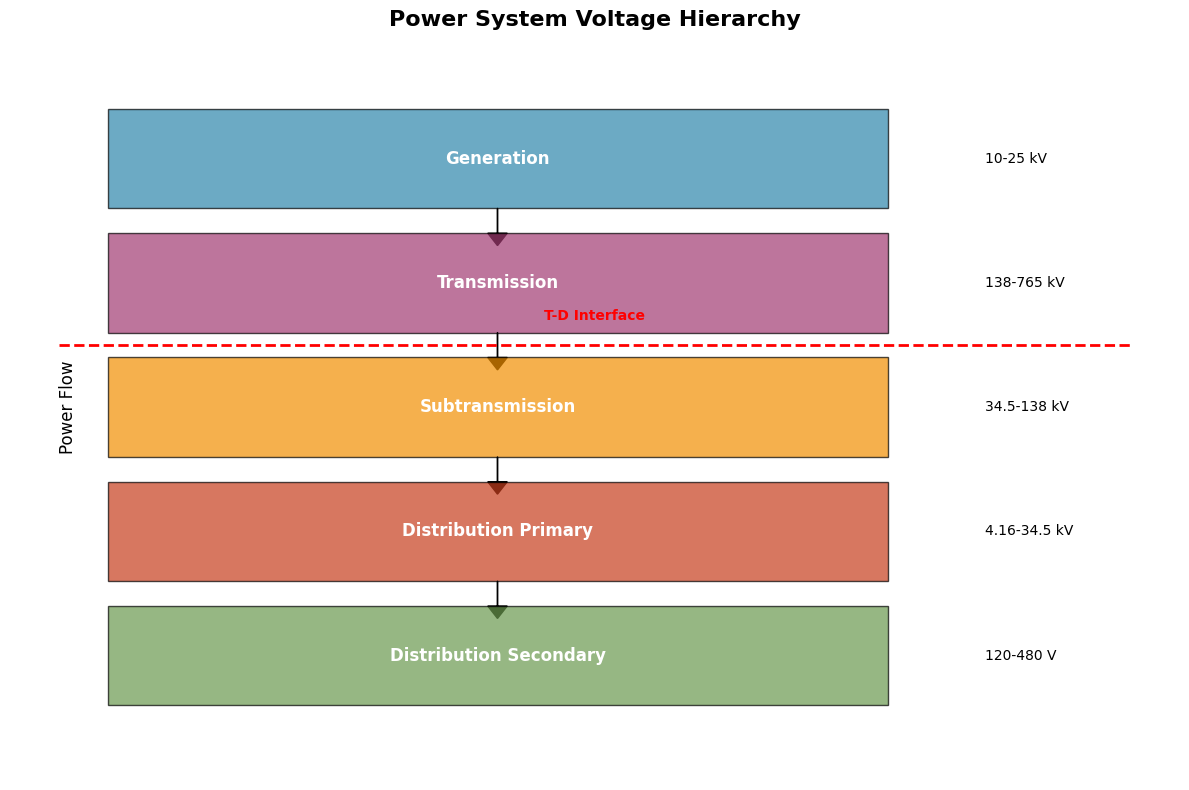

In [3]:
# Visualize the power system hierarchy
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Define system levels
levels = {
    'Generation': {'y': 5, 'voltage': '10-25 kV', 'color': '#2E86AB'},
    'Transmission': {'y': 4, 'voltage': '138-765 kV', 'color': '#A23B72'},
    'Subtransmission': {'y': 3, 'voltage': '34.5-138 kV', 'color': '#F18F01'},
    'Distribution Primary': {'y': 2, 'voltage': '4.16-34.5 kV', 'color': '#C73E1D'},
    'Distribution Secondary': {'y': 1, 'voltage': '120-480 V', 'color': '#6A994E'}
}

# Draw the hierarchy
for i, (level, props) in enumerate(levels.items()):
    # Draw level box
    
    rect = plt.Rectangle((1, props['y']-0.4), 8, 0.8,
                         facecolor=props['color'], alpha=0.7, edgecolor='black')
    ax.add_patch(rect)
    
    # Add text
    ax.text(5, props['y'], level, ha='center', va='center',
             fontsize=12, fontweight='bold', color='white')
    ax.text(10, props['y'], props['voltage'], ha='left', va='center', fontsize=10)
    
    # Draw connections
    if i < len(levels) - 1:
        ax.arrow(5, props['y']-0.4, 0, -0.2, head_width=0.2, head_length=0.1,
                 fc='black', ec='black')

# Add title and labels
ax.set_xlim(0, 12)
ax.set_ylim(0, 6)
ax.set_title('Power System Voltage Hierarchy', fontsize=16, fontweight='bold')
ax.text(0.5, 3, 'Power Flow', rotation=90, va='center', fontsize=12)
ax.axis('off')

# Add T-D interface indicator
ax.plot([0.5, 11.5], [3.5, 3.5], 'r--', linewidth=2)
ax.text(6, 3.7, 'T-D Interface', ha='center', color='red', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Why Separate Simulators?

The fundamental question students often ask is: why not model everything in one comprehensive simulator? The answer lies in computational efficiency, modeling fidelity, and practical software engineering considerations.

### Computational Complexity

Consider the scale difference between transmission and distribution systems. A regional transmission network might have 1,000 buses, while the distribution systems it serves could contain 100,000 or more nodes when modeled in detail. If we attempted to solve this entire system simultaneously, we would face several challenges.

First, the numerical properties of the combined system would be poor. Transmission lines have relatively low resistance-to-reactance ratios (R/X), while distribution systems have higher R/X ratios. Combining these in a single matrix leads to poor conditioning and convergence difficulties.

Second, the time scales of interest differ significantly. Transmission studies often require sub-second dynamics for stability analysis, while distribution planning studies might use hourly or 15-minute intervals. A unified simulator would need to accommodate the finest time scale across the entire system, leading to unnecessary computation.

### Modeling Philosophy

Different engineering communities have developed distinct modeling approaches optimized for their specific needs. Transmission engineers developed tools like PSS/E, PowerWorld and ANDES that excel at dynamic security assessment and planning. These tools use positive-sequence models that assume balanced three-phase operation, which is a reasonable approximation at transmission voltages.

Distribution engineers created tools like OpenDSS and CYME that handle unbalanced operation, detailed equipment models, and radial power flow algorithms. These tools can model individual customer loads and distributed energy resources with the detail needed for distribution planning.

Attempting to merge these modeling philosophies would compromise both. Transmission studies don't need three-phase unbalanced models for every distribution feeder, and distribution studies don't need generator swing equations for every transmission plant. Separate simulators allow each domain to use fit-for-purpose models.

## Manual Calculation Exercise

Before diving into automated co-simulation, let's build intuition by manually calculating power flow across a transmission-distribution interface. This exercise demonstrates the fundamental data exchange that co-simulation automates.

### Problem Setup

Consider a simple two-bus system where Bus 1 represents a transmission substation and Bus 2 represents an aggregated distribution load. The transmission bus maintains a voltage of 1.05 per unit at 0 degrees. The distribution system draws 50 MW and 10 MVAr. A line with impedance Z = 0.01 + j0.03 per unit connects them.

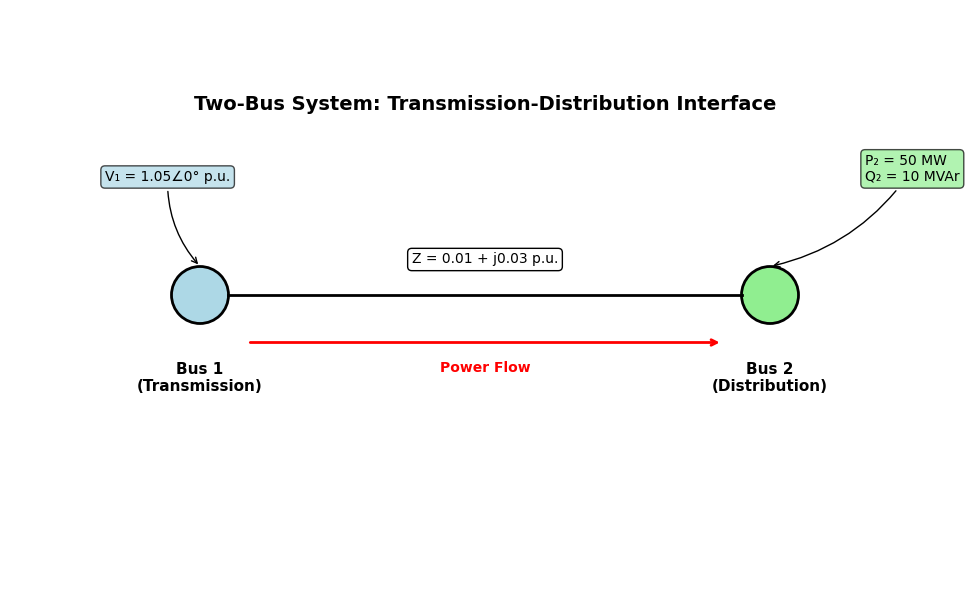

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Rectangle, Circle
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Define positions
bus1_x, bus1_y = 2, 3
bus2_x, bus2_y = 8, 3

# Draw buses as circles
bus1 = Circle((bus1_x, bus1_y), 0.3, fill=True, facecolor='lightblue', edgecolor='black', linewidth=2)
bus2 = Circle((bus2_x, bus2_y), 0.3, fill=True, facecolor='lightgreen', edgecolor='black', linewidth=2)
ax.add_patch(bus1)
ax.add_patch(bus2)

# Draw transmission line
ax.plot([bus1_x + 0.3, bus2_x - 0.3], [bus1_y, bus2_y], 'k-', linewidth=2)

# Add impedance label on the line
mid_x = (bus1_x + bus2_x) / 2
mid_y = (bus1_y + bus2_y) / 2
ax.text(mid_x, mid_y + 0.3, 'Z = 0.01 + j0.03 p.u.',
      ha='center', va='bottom', fontsize=10,
      bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))

# Add bus labels
ax.text(bus1_x, bus1_y - 0.7, 'Bus 1\n(Transmission)', ha='center', va='top', fontsize=11, fontweight='bold')
ax.text(bus2_x, bus2_y - 0.7, 'Bus 2\n(Distribution)', ha='center', va='top', fontsize=11, fontweight='bold')

# Add voltage annotation for Bus 1
ax.annotate('V₁ = 1.05∠0° p.u.',
          xy=(bus1_x, bus1_y + 0.3),
          xytext=(bus1_x - 1, bus1_y + 1.2),
          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),
          fontsize=10,
          bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))

# Add power annotation for Bus 2
ax.annotate('P₂ = 50 MW\nQ₂ = 10 MVAr',
          xy=(bus2_x, bus2_y + 0.3),
          xytext=(bus2_x + 1, bus2_y + 1.2),
          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2'),
          fontsize=10,
          bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))

# Add power flow arrow
arrow_start_x = bus1_x + 0.5
arrow_end_x = bus2_x - 0.5
arrow_y = bus1_y - 0.5
ax.annotate('', xy=(arrow_end_x, arrow_y), xytext=(arrow_start_x, arrow_y),
          arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax.text(mid_x, arrow_y - 0.2, 'Power Flow', ha='center', va='top',
      fontsize=10, color='red', fontweight='bold')

# Add title
ax.text(5, 5, 'Two-Bus System: Transmission-Distribution Interface',
      ha='center', va='center', fontsize=14, fontweight='bold')

# Set axis properties
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.set_aspect('equal')
ax.axis('off')

# Add grid background
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

In [5]:
# Manual power flow calculation
import cmath
import math

# Given parameters
V1_mag = 1.05  # Transmission bus voltage magnitude (pu)
V1_angle = 0.0  # Transmission bus voltage angle (radians)
P_load = 50.0  # Distribution load active power (MW)
Q_load = 10.0  # Distribution load reactive power (MVAr)
Z_line = 0.01 + 0.03j  # Line impedance (pu)
S_base = 100.0  # Base power (MVA)

# Convert to per unit
P_load_pu = P_load / S_base
Q_load_pu = Q_load / S_base
S_load_pu = P_load_pu - 1j * Q_load_pu  # Note: load convention (consuming power)

# Step 1: Calculate voltage at transmission bus
V1 = V1_mag * cmath.exp(1j * V1_angle)
print(f"Step 1: Transmission bus voltage")
print(f"V1 = {V1_mag:.4f} ∠ {math.degrees(V1_angle):.1f}° pu")
print(f"V1 = {V1.real:.4f} + j{V1.imag:.4f} pu\n")

# Step 2: Initial estimate of current (assuming V2 ≈ V1)
I_line = S_load_pu.conjugate() / V1.conjugate()
print(f"Step 2: Initial current estimate")
print(f"I = S*/V1* = {abs(I_line):.4f} ∠ {math.degrees(cmath.phase(I_line)):.1f}° pu")
print(f"I = {I_line.real:.4f} + j{I_line.imag:.4f} pu\n")

Step 1: Transmission bus voltage
V1 = 1.0500 ∠ 0.0° pu
V1 = 1.0500 + j0.0000 pu

Step 2: Initial current estimate
I = S*/V1* = 0.4856 ∠ 11.3° pu
I = 0.4762 + j0.0952 pu



In [6]:
# Step 3: Calculate voltage drop
V_drop = I_line * Z_line
print(f"Step 3: Voltage drop across line")
print(f"ΔV = I × Z = {abs(V_drop):.4f} ∠ {math.degrees(cmath.phase(V_drop)):.1f}° pu")
print(f"ΔV = {V_drop.real:.4f} + j{V_drop.imag:.4f} pu\n")

# Step 4: Calculate distribution bus voltage
V2 = V1 - V_drop
V2_mag = abs(V2)
V2_angle = cmath.phase(V2)
print(f"Step 4: Distribution bus voltage")
print(f"V2 = V1 - ΔV = {V2_mag:.4f} ∠ {math.degrees(V2_angle):.1f}° pu")
print(f"V2 = {V2.real:.4f} + j{V2.imag:.4f} pu\n")

Step 3: Voltage drop across line
ΔV = I × Z = 0.0154 ∠ 82.9° pu
ΔV = 0.0019 + j0.0152 pu

Step 4: Distribution bus voltage
V2 = V1 - ΔV = 1.0482 ∠ -0.8° pu
V2 = 1.0481 + j-0.0152 pu



In [7]:
# Step 5: Verify power balance
S_line_send = V1 * I_line.conjugate()
S_line_recv = V2 * I_line.conjugate()
S_loss = S_line_send - S_line_recv

print(f"Step 5: Power balance verification")
print(f"Power sent from transmission: {S_line_send.real*S_base:.2f} MW, {-S_line_send.imag*S_base:.2f} MVAr")
print(f"Power received at distribution: {S_line_recv.real*S_base:.2f} MW, {-S_line_recv.imag*S_base:.2f} MVAr")
print(f"Line losses: {S_loss.real*S_base:.2f} MW, {-S_loss.imag*S_base:.2f} MVAr")

Step 5: Power balance verification
Power sent from transmission: 50.00 MW, 10.00 MVAr
Power received at distribution: 49.76 MW, 10.71 MVAr
Line losses: 0.24 MW, -0.71 MVAr


### Key Insights from Manual Calculation

This simple calculation reveals several important concepts that carry over to full co-simulation:

1. **Data Exchange**: The transmission system provides voltage (magnitude and angle), while the distribution system provides power consumption. This defines the interface variables for co-simulation.

2. **Coupling**: Changes in distribution load directly affect transmission bus voltage through the line impedance. Similarly, transmission voltage variations impact distribution system operation.

3. **Iteration**: In practice, we would iterate this calculation because the distribution load might depend on voltage. Co-simulation handles this iteration automatically.

4. **Scaling**: Real systems have thousands of buses, but the fundamental principle remains: exchange voltage and power information at interface buses.

## Co-simulation Architecture Design

Now that we understand the manual process, let's explore the co-simulation architecture that automates this data exchange.

### System Configuration

For educational purposes, a typical co-simulation setup includes:
- **Transmission**: IEEE 14-bus system or similar with generators, loads, and interface buses
- **Distribution**: IEEE 34-bus or similar radial feeder with residential/commercial loads
- **Interface**: Designated buses where the systems connect

This configuration allows us to study realistic interactions while maintaining computational tractability.

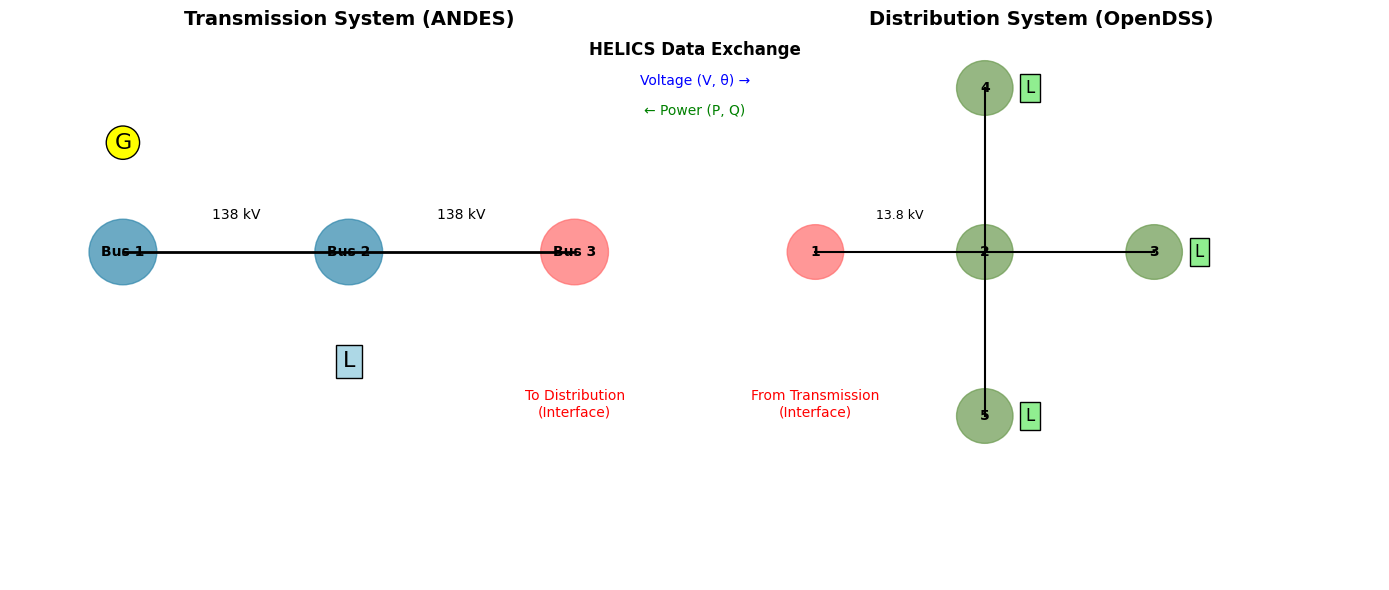

In [9]:
# Visualize the co-simulation architecture
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Transmission system diagram
ax1.set_title('Transmission System (ANDES)', fontsize=14, fontweight='bold')
ax1.set_xlim(-1, 5)
ax1.set_ylim(-1, 4)

# Transmission buses
trans_buses = [(0, 2), (2, 2), (4, 2)]  # Bus 1, 2, 3
for i, (x, y) in enumerate(trans_buses):
    color = '#2E86AB' if i < 2 else '#FF6B6B'  # Red for interface bus
    circle = plt.Circle((x, y), 0.3, color=color, alpha=0.7)
    ax1.add_patch(circle)
    ax1.text(x, y, f'Bus {i+1}', ha='center', va='center', fontweight='bold')

# Transmission lines
ax1.plot([0, 2], [2, 2], 'k-', linewidth=2)
ax1.plot([2, 4], [2, 2], 'k-', linewidth=2)

# Generator and load symbols
ax1.text(0, 3, 'G', ha='center', va='center', fontsize=16,
          bbox=dict(boxstyle="circle", facecolor='yellow'))
ax1.text(2, 1, 'L', ha='center', va='center', fontsize=16,
         bbox=dict(boxstyle="square", facecolor='lightblue'))

# Labels
ax1.text(1, 2.3, '138 kV', ha='center', fontsize=10)
ax1.text(3, 2.3, '138 kV', ha='center', fontsize=10)
ax1.text(4, 0.5, 'To Distribution\n(Interface)', ha='center', color='red')
ax1.axis('off')

# Distribution system diagram
ax2.set_title('Distribution System (OpenDSS)', fontsize=14, fontweight='bold')
ax2.set_xlim(-1, 5)
ax2.set_ylim(-1, 4)

# Distribution buses
dist_buses = [(0, 2), (1.5, 2), (3, 2), (1.5, 3.5), (1.5, 0.5)]
for i, (x, y) in enumerate(dist_buses):
    color = '#FF6B6B' if i == 0 else '#6A994E'  # Red for interface
    circle = plt.Circle((x, y), 0.25, color=color, alpha=0.7)
    ax2.add_patch(circle)
    ax2.text(x, y, f'{i+1}', ha='center', va='center', fontweight='bold', fontsize=10)

# Distribution lines
ax2.plot([0, 1.5], [2, 2], 'k-', linewidth=1.5)
ax2.plot([1.5, 3], [2, 2], 'k-', linewidth=1.5)
ax2.plot([1.5, 1.5], [2, 3.5], 'k-', linewidth=1.5)
ax2.plot([1.5, 1.5], [2, 0.5], 'k-', linewidth=1.5)

# Load symbols
for (x, y) in [(3, 2), (1.5, 3.5), (1.5, 0.5)]:
    ax2.text(x+0.4, y, 'L', ha='center', va='center', fontsize=12,
             bbox=dict(boxstyle="square", facecolor='lightgreen'))

# Voltage levels
ax2.text(0.75, 2.3, '13.8 kV', ha='center', fontsize=9)
ax2.text(0, 0.5, 'From Transmission\n(Interface)', ha='center', color='red')
ax2.axis('off')

# Add data flow indicators
fig.text(0.5, 0.9, 'HELICS Data Exchange', ha='center', fontsize=12, fontweight='bold')
fig.text(0.5, 0.85, 'Voltage (V, θ) →', ha='center', fontsize=10, color='blue')
fig.text(0.5, 0.80, '← Power (P, Q)', ha='center', fontsize=10, color='green')

plt.tight_layout()
plt.show()

### Interface Definition

The interface between transmission and distribution systems is where co-simulation magic happens. At this boundary, we need to:

1. **From Transmission to Distribution**: Provide voltage magnitude and angle at the high-voltage side of the substation transformer
2. **From Distribution to Transmission**: Provide the total active and reactive power drawn by the distribution system

This creates a closed loop where transmission voltage affects distribution power consumption, which in turn affects transmission voltage. HELICS manages the timing and data exchange to ensure both simulators stay synchronized.

## HELICS Federation Concepts

HELICS provides the infrastructure for co-simulation through several key concepts:

### Core Components

1. **Broker**: Central coordination hub managing communication between federates
2. **Federates**: Individual simulators (e.g., ANDES for transmission, OpenDSS for distribution)
3. **Publications/Subscriptions**: Data exchange interfaces between federates
4. **Time Management**: Ensures synchronized advancement through simulation time

### Data Exchange Pattern

The typical T&D co-simulation data exchange follows this pattern:

1. Transmission federate publishes voltage at interface bus
2. Distribution federate subscribes to this voltage
3. Distribution federate updates its source voltage
4. Distribution federate solves power flow
5. Distribution federate publishes total power demand
6. Transmission federate subscribes to this power
7. Transmission federate updates interface load
8. Both federates advance to next time step

This cycle repeats throughout the simulation, with HELICS ensuring proper synchronization.

## Simple Conceptual Demo

Let's create a simple conceptual demonstration of the co-simulation data flow without full implementation details:

In [11]:
# Conceptual co-simulation demo (simplified)
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
time_steps = 20
time = np.arange(time_steps)

# Initialize arrays
voltage_mag = np.zeros(time_steps)
voltage_ang = np.zeros(time_steps)
power_p = np.zeros(time_steps)
power_q = np.zeros(time_steps)

# Initial conditions
v_base = 1.05  # Base voltage
p_base = 50.0  # Base power (MW)
q_base = 10.0  # Base reactive power (MVAr)

print("Conceptual T&D Co-simulation Data Exchange")
print("=" * 50)
print("Time | V_mag | V_ang | P_load | Q_load")
print("-----+-------+-------+--------+-------")

# Simulate data exchange
for t in range(time_steps):
    # Distribution load varies sinusoidally
    load_factor = 1.0 + 0.2 * np.sin(2 * np.pi * t / 20)
    
    # Distribution system calculates power demand
    power_p[t] = p_base * load_factor
    power_q[t] = q_base * load_factor
    
    # Transmission system responds to load change
    # Voltage drops slightly with increased load
    voltage_mag[t] = v_base - 0.001 * (power_p[t] - p_base)
    voltage_ang[t] = -0.01 * (power_p[t] - p_base)  # Angle shifts with load
    
    # Print first 5 time steps
    if t < 5:
        print(f" {t:2d}  | {voltage_mag[t]:.3f} | {voltage_ang[t]:6.3f} | {power_p[t]:6.1f} | {power_q[t]:6.1f}")

print(" ... |  ...  |   ...  |   ...  |  ...")
print(f" {time_steps-1:2d}  | {voltage_mag[-1]:.3f} | {voltage_ang[-1]:6.3f} | {power_p[-1]:6.1f} | {power_q[-1]:6.1f}")

Conceptual T&D Co-simulation Data Exchange
Time | V_mag | V_ang | P_load | Q_load
-----+-------+-------+--------+-------
  0  | 1.050 | -0.000 |   50.0 |   10.0
  1  | 1.047 | -0.031 |   53.1 |   10.6
  2  | 1.044 | -0.059 |   55.9 |   11.2
  3  | 1.042 | -0.081 |   58.1 |   11.6
  4  | 1.040 | -0.095 |   59.5 |   11.9
 ... |  ...  |   ...  |   ...  |  ...
 19  | 1.053 |  0.031 |   46.9 |    9.4


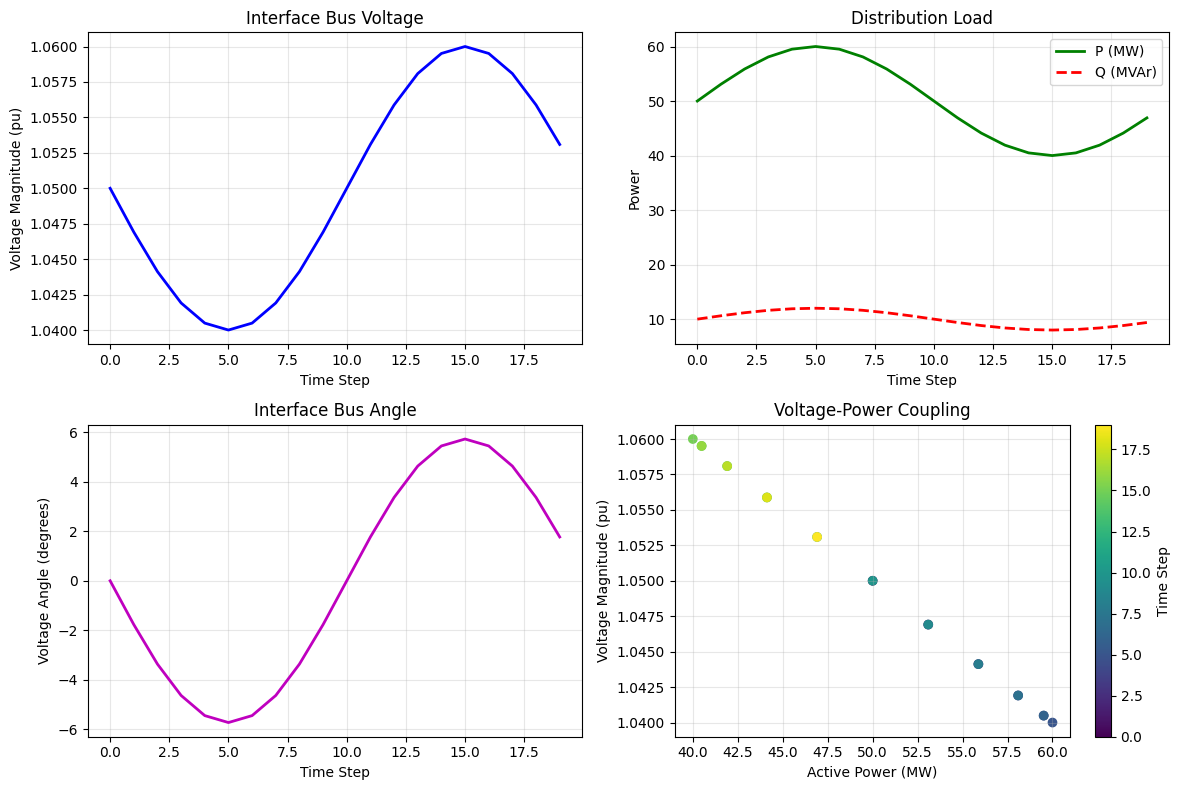


This conceptual demo shows the key data exchange pattern.
Full implementation details are in the next notebooks.


In [12]:
# Visualize results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Voltage magnitude
ax1.plot(time, voltage_mag, 'b-', linewidth=2)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Voltage Magnitude (pu)')
ax1.set_title('Interface Bus Voltage')
ax1.grid(True, alpha=0.3)

# Power demand
ax2.plot(time, power_p, 'g-', linewidth=2, label='P (MW)')
ax2.plot(time, power_q, 'r--', linewidth=2, label='Q (MVAr)')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Power')
ax2.set_title('Distribution Load')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Voltage angle
ax3.plot(time, np.degrees(voltage_ang), 'm-', linewidth=2)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Voltage Angle (degrees)')
ax3.set_title('Interface Bus Angle')
ax3.grid(True, alpha=0.3)

# V-P relationship
ax4.scatter(power_p, voltage_mag, c=time, cmap='viridis')
ax4.set_xlabel('Active Power (MW)')
ax4.set_ylabel('Voltage Magnitude (pu)')
ax4.set_title('Voltage-Power Coupling')
ax4.grid(True, alpha=0.3)
cbar = plt.colorbar(ax4.collections[0], ax=ax4)
cbar.set_label('Time Step')

plt.tight_layout()
plt.show()

print("\nThis conceptual demo shows the key data exchange pattern.")
print("Full implementation details are in the next notebooks.")

## Next Steps: Full Implementation

Now that you understand the fundamental concepts of T&D co-simulation, the next notebooks provide complete, working implementations:

### 1. transmission_federate.ipynb
- Detailed setup of IEEE 14-bus transmission system using ANDES
- HELICS federate configuration for transmission
- Dynamic simulation capabilities
- Interface bus management and scaling

### 2. distribution_federate.ipynb  
- IEEE 34-bus distribution system implementation with OpenDSS
- Three-phase unbalanced power flow
- Load variation modeling
- Voltage regulation equipment

### Key Features of the Full Implementation:
- **Simultaneous Execution**: Both notebooks run together to demonstrate real co-simulation
- **Realistic Systems**: IEEE test systems with actual parameters
- **Dynamic Behavior**: Time-varying loads and system responses
- **Detailed Logging**: Step-by-step data exchange visualization
- **Results Analysis**: Comprehensive plotting and performance metrics

### How to Run the Complete Co-simulation:

1. Open both `transmission_federate.ipynb` and `distribution_federate.ipynb` in separate Jupyter tabs
2. Run all cells in both notebooks simultaneously (they will synchronize through HELICS)
3. Observe the real-time data exchange in the output
4. Analyze the results showing voltage-power coupling

The separation into dedicated federate notebooks allows you to:
- Focus on domain-specific implementation details
- Understand how each simulator is configured
- See the actual HELICS communication in action
- Modify and experiment with each system independently

## Summary

In this notebook, we've covered the fundamental concepts of power system co-simulation:

1. **System Differences**: Understood why transmission and distribution systems require different modeling approaches
2. **Co-simulation Motivation**: Learned why separate simulators are necessary and beneficial
3. **Manual Calculations**: Worked through the basic power flow equations that co-simulation automates
4. **Architecture Concepts**: Explored the HELICS federation structure and data exchange patterns
5. **Interface Design**: Understood the critical voltage-power data exchange at T&D boundaries

### Key Takeaways:

- Co-simulation enables analysis of interactions between different power system domains
- The T&D interface exchanges voltage (from transmission) and power (from distribution)
- HELICS provides the infrastructure for synchronized multi-simulator execution
- Manual calculations help build intuition for automated co-simulation

### Moving Forward:

With these concepts understood, you're ready to implement real co-simulations using the transmission and distribution federate notebooks. These provide hands-on experience with:
- Configuring actual power system simulators
- Setting up HELICS communication
- Running synchronized co-simulations
- Analyzing realistic system interactions

The transition from concepts to implementation is crucial for mastering T&D co-simulation techniques that are increasingly important for modern grid analysis.

## References and Further Reading

1. Palmintier, B., et al. "Design of the HELICS High-Performance Transmission-Distribution-Communication-Market Co-Simulation Framework." 2017 Workshop on Modeling and Simulation of Cyber-Physical Energy Systems (MSCPES), 2017.

2. HELICS Documentation: https://docs.helics.org/